## Connecting to Federated Query Executed System

### Presto
``
conn = presto.Connection(host="presto", port=8080, user="demo")
cur = conn.cursor()
``
### Drill
``drill = PyDrill(host='drill', port=8047)``
### Spark
TODO
### Hive
TODO


In [1]:
%pip install pathlib
%pip install jinja2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
import jinja2
import prestodb.dbapi as presto
from pydrill.client import PyDrill
import pandas as pd
import time

In [3]:
# configure sources
def get_sources_config(scale,**kwargs):
    """Returns a dict with tabels maped to sources"""
    mapped = {
        "lineitem":f"{kwargs['li_source']}.public.{kwargs['li_source'][:-1]}_{scale}_lineitem",
        "orders":f"{kwargs['o_source']}.public.{kwargs['o_source'][:-1]}_{scale}_orders",
        "customer":f"{kwargs['c_source']}.public.{kwargs['c_source'][:-1]}_{scale}_customer",
        "part":f"{kwargs['pa_source']}.public.{kwargs['pa_source'][:-1]}_{scale}_part",
        "supplier":f"{kwargs['s_source']}.public.{kwargs['s_source'][:-1]}_{scale}_supplier",
        "partsupp":f"{kwargs['ps_source']}.public.{kwargs['ps_source'][:-1]}_{scale}_partsupp",
        "nation":f"{kwargs['n_source']}.public.{kwargs['n_source'][:-1]}_{scale}_nation",
        "region":f"{kwargs['r_source']}.public.{kwargs['r_source'][:-1]}_{scale}_region"
    }
    return mapped

In [4]:
def get_queries():
    return [q for q in Path("./queries").iterdir()]

def render_queries(sources_config,queries_path):
    """Returns a dict where the key is the tpch query name and the value is the rendered query"""
    result = {}
    for path in queries_path:
        key = path.name.split(".")[0]
        value = jinja2.Template(path.read_text()).render(**sources_config)
        result[key]=value
    return result

In [5]:
class Presto():
    def __init__(self,host="presto",port=8080,user="demo"):
        self.conn = presto.Connection(host="presto", port=8080, user="demo")
        self.cur = self.conn.cursor()
    
    def run_query(self,sql,show=False):
        self.cur.execute(sql)
        result = self.cur.fetchall()
        if show:
            return result

In [6]:
class Drill(PyDrill):
    def __init__(self,**kwargs):
        PyDrill.__init__(self, **kwargs)
        
    def run_query(self,sql,timeout=100000,show=False):
        if show:
            return self.query(sql,timeout=timeout).to_dataframe()
        return self.query(sql,timeout=timeout)

In [7]:
drill = Drill(host='drill', port=8047)

if not drill.is_active():
    raise ValueError('Please run Drill first')

presto = Presto()

# Benchmark

In [8]:
def benchmark(system,query,iterations=1):
    sum = 0
    count = 0
    for _ in range(iterations):
        count = count + 1
        start = time.time()
        system.run_query(query)
        end = time.time()
        sum = sum + (end - start)
    return sum/count

In [9]:
mixed_sources={
    "li_source":"pg1",
    "o_source":"mysql1",
    "c_source":"pg3",
    "pa_source":"pg4",
    "s_source":"mysql1",
    "ps_source":"mysql2",
    "n_source":"pg3",
    "r_source":"pg4",
}
config_sf1_mixed = get_sources_config(scale="sf1",**mixed_sources)
query_dict = render_queries(sources_config=config_sf1_mixed,queries_path=get_queries())

In [10]:
# q2, q9, q11 -> cannot run as ps_supplycost column by partsupp is not shown by presto
presto_benchmark_results=[]

In [11]:
presto_benchmark_results.append(benchmark(presto,query_dict["q1"],iterations=10))

In [12]:
presto_benchmark_results.append(benchmark(presto,query_dict["q2"],iterations=10))

In [13]:
presto_benchmark_results.append(benchmark(presto,query_dict["q3"],iterations=10))

In [14]:
presto_benchmark_results.append(benchmark(presto,query_dict["q4"],iterations=10))

In [15]:
presto_benchmark_results.append(benchmark(presto,query_dict["q5"],iterations=10))

In [16]:
drill_benchmark_results=[]

In [17]:
drill_benchmark_results.append(benchmark(drill,query_dict["q1"],iterations=10))
# planning stage takes some time for the first run. then some kind of caching is happening.
# check for plan differences

In [22]:
drill_benchmark_results.append(benchmark(drill,query_dict["q2"],iterations=10))
# changed planner.memory.max_query_memory_per_node at options to max: 5900000000

In [23]:
drill_benchmark_results.append(benchmark(drill,query_dict["q3"],iterations=10))

In [24]:
drill_benchmark_results.append(benchmark(drill,query_dict["q4"],iterations=10))

In [26]:
# drill_benchmark_results.append(benchmark(drill,query_dict["q5"],iterations=10))
# query took 13 min to run -> had to manually stop it
# next iteration throws: "RESOURCE ERROR: There is not enough heap memory to run this query using the web interface.
# I can raise the heap memory further on, but the query should's take longer than 2 min. 
drill_benchmark_results.append(0)

In [ ]:
pg_sources={
    "li_source":"pg1",
    "o_source":"mysql1",
    "c_source":"pg3",
    "pa_source":"pg4",
    "s_source":"mysql1",
    "ps_source":"mysql2",
    "n_source":"pg3",
    "r_source":"pg4",
}
config_pg_mixed = get_sources_config(scale="sf1",**pg_sources)
query_dict = render_queries(sources_config=config_pg_mixed,queries_path=get_queries())

In [ ]:
mysql_sources={
    "li_source":"pg1",
    "o_source":"mysql1",
    "c_source":"pg3",
    "pa_source":"pg4",
    "s_source":"mysql1",
    "ps_source":"mysql2",
    "n_source":"pg3",
    "r_source":"pg4",
}
config_mysql_mixed = get_sources_config(scale="sf1",**mysql_sources)
query_dict = render_queries(sources_config=config_mysql_mixed,queries_path=get_queries())

In [27]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


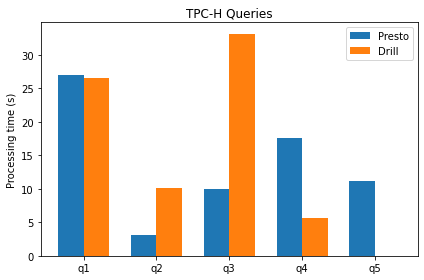

In [29]:
import matplotlib.pyplot as plt
import numpy as np
labels = ["q1","q2","q3","q4","q5"]
x = np.arange(len(labels))
width = 0.35 
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, presto_benchmark_results, width, label='Presto')
rects2 = ax.bar(x + width/2, drill_benchmark_results, width, label='Drill')

ax.set_ylabel('Processing time (s)')
ax.set_title('TPC-H Queries')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## Create a Table in MySQL

Let's use the MySQL client to create the table. Then we will switch to Presto to manipulate the data:

In [ ]:
# import MySQLdb

# mysql = MySQLdb.connect(host="mysql", user="root", passwd="mysql")
# cur = mysql.cursor()
# cur.execute("CREATE DATABASE IF NOT EXISTS presto")
# cur.fetchall()
# cur.execute("""
#     CREATE TABLE IF NOT EXISTS presto.events (event LONGTEXT)
#     CHARSET utf8mb4 ENGINE=InnoDB
# """)
# cur.fetchall()
# cur.execute("DESC presto.events")
# for row in cur.fetchall():
#     print("{table}: [{props}]".format(
#         table=row[0],
#         props=', '.join(str(i) for i in row[1:])))

## Load Data in MySQL

Let's now load data from [GH Archive](http://www.gharchive.org/) into MySQL and MongoDB.
Each file from GH Archive contains lines of JSON structs that represent events from the public GitHub timeline, for example repository creation or code push.

Now that the table is create in MySQL, we can insert rows with Presto by using the existing `conn` object created above. You can open http://localhost:8080 to see the execution Presto queries.

In [ ]:
# import gzip
# import io
# import json
# import re
# import requests

# # Load events happening between 4-5pm.
# # Feel free to load more hours or more days.
# # We limit the dataset to one hour here to not overload
# # the machine that will run the queries as this tutorial
# # is expected to run on a laptop.
# # It is going to take some time. For the demo, i pre-loaded
# # the data with the mysql client to avoid the overhead of creating
# # Python objects.
# zdata = requests.get("https://data.gharchive.org/2015-04-28-16.json.gz")
# data = gzip.decompress(zdata.content)
# rows = []

# # load ``ROW_COUNT`` rows. Feel free to set a greater value if it
# # works well in your environment. Using a small value on purpose
# # to avoid loading data for a long time.
# ROW_COUNT = 1000
# cur = conn.cursor()
# for n, line in enumerate(io.BytesIO(data)):
#     row = line.strip().decode('utf8')
#     sql = "INSERT INTO mysql.presto.events (event) VALUES ('{}')".format(row.replace("'", "''"))
#     cur.execute(sql)
#     cur.fetchall()
#     if n == ROW_COUNT - 1:
#         break

In [ ]:
# cur = conn.cursor()
# cur.execute("SELECT json_extract(json_parse(event), '$.type') FROM mysql.presto.events TABLESAMPLE BERNOULLI (1) LIMIT 1")
# cur.fetchall()

In [ ]:
# cur = conn.cursor()
# cur.execute("""
#     SELECT ev_type, repo_name, count(*) FROM (
#       SELECT
#         TRY(json_extract_scalar(ev, '$.repo.name')) as repo_name,
#         TRY(json_extract_scalar(ev, '$.type')) as ev_type FROM (
#           SELECT try(json_parse(event)) as ev FROM mysql.presto.events))
#     WHERE repo_name is not null and ev_type = 'PushEvent'
#     GROUP BY ev_type, repo_name
#     ORDER BY 3 DESC
#     LIMIT 10
# """)
# rows = cur.fetchall()
# import pandas as pd
# from IPython.display import display

# print(rows)
# df = pd.DataFrame(sorted(rows, key=lambda x: x[2], reverse=True))
# display(df)

In [ ]:
# cur = conn.cursor()
# cur.execute("CREATE TABLE mongodb.events.all AS SELECT * FROM mysql.presto.events")
# cur.fetchall()